# Computer Vision Lab Project - JKU - 2021
### Team B0
  
Team Members: Philipp Eberstaller, Dominik Heindl and Carson Wittwer

## Function and Utility Setup
### Imports

In [47]:
from abc import ABC, abstractmethod
import glob
import json
import os
import copy
from time import time, gmtime, strftime
from typing import Tuple, Dict, List
from IPython.display import clear_output
import warnings
warnings.filterwarnings('ignore')

import cv2
import matplotlib.pyplot as plt
import numpy as np

import utils as ut

### Utilities
#### Loading Data Utilities

Provides output for maintaining consistent structures of our import data

In [48]:
def load_homographies(input_dir: str):
    """
    Finds all homographies.json files recursively in a given input directory.

    Args:
        input_dir: Input directory which contains .json files

    Returns:
        A dictionary mapping the folder names to dictionaries with the homographies
        Each dictionary is structured as follows:
            {Folder Name (e.g. "valid-1-0"): {File Name (e.g. 0-B01): List[homographies]}}}
    """
    sorted_homographies = sorted(glob.glob(
        os.path.join(input_dir, '**', '*ies.json'),
        recursive=True
    ))

    homographies = {}

    for file in sorted_homographies:
        folders, file_name = os.path.split(file)
        folder_name = os.path.basename(folders)

        homographies[folder_name] = json.loads(open(file, 'r').read())

    return homographies

def read_images(
        input_dir: str,
        mask: np.ndarray,
        integrated_only: bool = True
) -> Tuple[Dict[str, Dict[str, Dict[str, np.ndarray]]], Dict[str, Dict[str, Dict[str, np.ndarray]]]]:
    """
    Finds all .png files recursively in a given input directory. The images are loaded,
    a mask is applied to filter unwanted regions of the images and the images get
    warped based on the provided homographies.
    With this dictionary structure it can be assured that the images of one
    image set always go together.

    Args:
        input_dir: Input directory which contains .png images
        mask: Filter to mask out unwanted regions of all images at the same position
        integrated_only: Whether to load only the integrated

    Returns:
        A tuple containing 2 dictionaries for the original and warped images.
        Each dictionary is structured as follows:
            {Folder Name (e.g. "valid-1-0"): {File Set Number (e.g. 0): {File Name (e.g. 0-B01): Image as array}}}
    """
    input_dir = os.path.abspath(input_dir)

    if integrated_only:
        sorted_files = sorted(glob.glob(
            os.path.join(input_dir, '**', '*-int_image.png'),
            recursive=True
        ))
    else:
        sorted_files = sorted(glob.glob(
            os.path.join(input_dir, '**', '*.png'),
            recursive=True
        ))

        homographies = load_homographies(input_dir)

    original_images = {}
    warped_images = {}

    for file in sorted_files:
        folders, file_name = os.path.split(file)

        file_name = file_name.split('.')[0]
        folder_name = os.path.basename(folders)
        file_set = file_name.split('-')[0]

        if folder_name not in original_images and folder_name not in warped_images:
                original_images[folder_name] = {}
                warped_images[folder_name] = {}

        if file_set not in original_images[folder_name] and file_set not in warped_images[folder_name]:
            original_images[folder_name].update({file_set: {}})
            warped_images[folder_name].update({file_set: {}})

        img = cv2.imread(file)

        if not integrated_only:
            if folder_name not in warped_images:
                warped_images[folder_name] = {}

            if file_set not  in warped_images[folder_name]:
                warped_images[folder_name].update({file_set: {}})

            w, h, _ = img.shape
            img = cv2.bitwise_and(img,img,mask=mask) #apply the mask to remove the timestamp

            homography = np.array(homographies[folder_name][file_name]) #get homography

            warped_img = cv2.warpPerspective(img, homography, (w,h)) #warp the image using the given homography
            warped_images[folder_name][file_set].update({file_name: warped_img})

        original_images[folder_name][file_set].update({file_name: img}) #save the original

    return original_images, warped_images


#### Other Utilities


In [49]:
def display_images(images, figsize=None, resize_dim=(200, 200)):
    if figsize: row, col = figsize
    else: row, col = 1,1
        
    fig, axs = plt.subplots(row, col, figsize=figsize)
    if row>1 or col>1: axs = axs.flatten()
    else: axs = [axs]
    fig.set_figwidth(20)
    fig.set_figheight(15)
    
    for img, ax in zip(images, axs):
        ax.imshow(cv2.resize(img, resize_dim), interpolation='nearest')
        
    plt.show()


def get_background_mean(images):
    return np.mean(images,axis=0).astype(np.uint8)

### Image Integration

Uses a mean to produce an integrated image of a series of warped images
Additionally, calculates a mask that provides area where all images overlapped and provided information

In [50]:
def integrate(images: list):

    """
    Takes a list of images and integrates them and returns the integrated image 
    and overlap mask where all 7 images overlap
    """
    integral = np.zeros((images[0].shape), np.float64)
    mask = np.zeros((images[0].shape), np.float64)
    mask = mask[:,:,0]
    mask_ = np.copy(mask)

    for j in range(len(images)):
        integral += images[j]
        
        a,b = np.where(np.all(images[j]==[0,0,0],axis=2))
        pix_locs = np.column_stack((a,b))
        for c,d in pix_locs:
            mask[c,d] += 1
    
    x,y = mask.shape
    for n in range(x):
        for m in range(y):
            if mask[n,m] == 0: #0 means this pixel has all 10 images merged
                mask_[n,m] = 1
            else:
                mask_[n,m] = 0

    integral /= len(images)
    integral=cv2.normalize(integral, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

    return integral, mask_

### Anomaly Detection
#### Base class definition
This baseclass can be considered an artifact as it was used in earlier stages of the project to unify the interface for different anomaly detection algorithms we tried.

In [51]:
class AnomalyDetection(ABC):
    def __init__(self, img: np.ndarray):
        self.img = img

    @abstractmethod
    def anomaly_mask(self) -> np.ndarray:
        """
        Takes whatever is necessary from the current object to generate an anomaly
        mask. The mask has the same height and width as the input image.
        """
        pass

#### Residual Approach

Originally this should be an implementation from `Reducing Anomaly Detection in Images to Detection in Noise` by Davy et al., however by pure chance we stumbled across the fact that a burred version of the residual image, as explained in this paper, is already looking promising for detecting outliers. The code for this approach is based on this [public repository](https://github.com/whynotw/reducing_anomaly_detection). <br>
A disadvantage of the current implementation is the runtime complexity of $\mathcal{O}(n^3)$ because of the usage of various for-loops. The algorithm initially took ~1min. per 1024$\times$1024 input image. After some modification in the form of reducing the input size to only relevant portions of the image, we were able to decrease the time to ~6sec. per image.

In [52]:
class ResidualAnomaly(AnomalyDetection):
    def __init__(
            self,
            img: np.ndarray,
            filter_size: int = 7,
            stride: int = 3,
            number_k: int = 5,
    ):
        super().__init__(img)
        if filter_size % 2 == 0:
            print("size of filter %d should be odd number" % filter_size)
        self.filter_size = filter_size
        self.stride = stride
        self.k = number_k

        self.image_origin = img
        h, w, _ = img.shape

        h_remain = (h - filter_size) % stride
        w_remain = (w - filter_size) % stride
        self.image_origin = self.image_origin[:h - h_remain, :w - w_remain, :]

        self.h, self.w, _ = self.image_origin.shape
        self.h_red = (self.h - self.filter_size) // self.stride + 1
        self.w_red  = (self.w - self.filter_size) // self.stride + 1
        self.dim_data = 3 * self.filter_size ** 2
        self.img_acc = np.zeros((self.h, self.w, 3), dtype=np.float32)
        self.pixel_count = np.zeros((self.h, self.w), dtype=np.uint8)

        tmp_idx = np.arange(0, self.w_red * self.stride, self.stride, dtype=np.uint16)
        self.x0_data = np.stack((tmp_idx, ) * self.h_red)
        self.x1_data = self.x0_data+self.filter_size

        tmp_idx = np.arange(0, self.h_red * self.stride, self.stride, dtype=np.uint16)
        self.y0_data = np.stack((tmp_idx, ) * self.w_red).T
        self.y1_data = self.y0_data+self.filter_size
        self.knn = cv2.ml.KNearest_create()

    def _create_patches(self):
        """
        Divides the given image into pathes with size filter_size x filter_size.
        The filter is then moves forward for stride pixels. All patches are saved
        in the data object for the knn algorithm.

        Returns:
            None
        """
        self.data_total  = np.empty((self.h_red, self.w_red, self.dim_data), dtype=np.uint8)
        self.label_total = np.empty((self.h_red, self.w_red, 1), dtype=np.float32)

        count = 0
        # loop over image and split it into patches for the knn algorithm
        for j in range(0, self.h_red):
            for i in range(0, self.w_red):
                x0 = i * self.stride
                x1 = x0 + self.filter_size
                y0 = j * self.stride
                y1 = y0 + self.filter_size
                self.data_total[j, i, :] = self.image_origin[y0:y1, x0:x1, :].reshape(-1)
                self.label_total[j, i, 0] = count
                count += 1

    def _get_knn(self):
        """
        Performs a knn algorithm on the previously calculated patches. This should
        ensure that anomalies are true anomalies and not part of some bigger pattern

        Returns:
            None
        """
        tmp_data = self.data_total.reshape((-1, self.dim_data)).astype(np.float32)

        # train a knn model to find the similarities between patches
        self.knn.train(
            tmp_data,
            cv2.ml.ROW_SAMPLE,
            self.label_total.reshape(-1,1)
        )

        _, _, neighbours, distances = self.knn.findNearest(
            tmp_data,
            self.filter_size ** 2 + self.k
        )
        neighbours = neighbours.astype(np.int64)

        return neighbours, distances

    def _get_self_similar_estimate(self):
        """
        Creates a "self-similar" version of each image patch which is later used
        to create the residual image. The average values of the neighbour patches
        are divided from the current patch.

        Returns:
            None
        """
        neighbours, distances = self._get_knn()

        count = 0
        for j in range(0, self.h_red):
            for i in range(0, self.w_red):
                patch = np.zeros((self.filter_size, self.filter_size, 3), dtype=np.float32)
                x0 = self.stride * i
                x1 = x0 + self.filter_size
                y0 = self.stride * j
                y1 = y0 + self.filter_size

                partition = 1e-7
                effective = -1

                for k in range(len(neighbours)):
                    n = neighbours[count][k]
                    j_neighbour = n // self.w_red
                    i_neighbour = n % self.w_red

                    d = distances[count][k]

                    x0_n = self.stride * i_neighbour
                    x1_n = x0_n + self.filter_size
                    y0_n = self.stride * j_neighbour
                    y1_n = y0_n + self.filter_size

                    if x0 > x1_n or x1 < x0_n or y0 > y1_n or y1 < y0_n:
                        effective += 1
                    else:
                        continue

                    if effective == 0:
                        d0 = d

                    if effective >= self.k:
                        break

                    d -= d0
                    factor = np.exp(-d/self.dim_data)

                    if factor > 2**-8:
                        patch += factor * (
                            self.data_total[j_neighbour,i_neighbour,:]
                                .reshape((self.filter_size, self.filter_size, 3))
                        )
                        partition += factor

                self.img_acc[y0:y1, x0:x1, :] += patch / partition
                self.pixel_count[y0:y1, x0:x1] += 1
                count += 1

        self.img_red = np.uint8(self.img_acc / np.stack((self.pixel_count,) * 3, axis=-1))

    def anomaly_mask(self):
        """
        Calculates the residual image -> original image - self similar version of it.
        Then apply a GaussianBlus which removes weak outlier signals.

        Returns:
            Anomaly mask where each pixel gets a value based on how likely it is
            an anomaly. The higher the value the more likely it is an anomaly.
        """
        self._create_patches()
        self._get_self_similar_estimate()

        tmp_residual = np.uint8(
            np.sum(
                np.abs(
                    np.int16(self.img_red) - np.int16(self.image_origin)
                ),
                axis=-1
            ) / 3
        )

        tmp_blurred = cv2.GaussianBlur(
            tmp_residual,
            (self.filter_size * 2 + 1,) * 2,
            0
        )

        return tmp_blurred

Function to calculate an anomaly mask given varying parameters. This uses the previously defined Residual approach but crops the input image before the anomaly detection step to lower the time it takes to compute.

In [53]:
def calculate_anomaly_mask(
        img: np.ndarray,
        overlapping_mask: np.ndarray,
        filter_size: int,
        stride: int,
        number_k: int
):
    """
    Calculate the anomaly masks with the Residual approach in a more efficient way
    by cropping only the center part where all cameras are overlapping. This info
    is provided by the overlapping mask which has to be computed beforehand.

    Args:
        img: Integrated image of which the anomaly mask should be computed
        overlapping_mask: 2D-array which indicates the area of the img which is part of all 10 camera views
        filter_size: Size of the filter used to create patches in the Residual anomaly detection
        stride: Number of pixels the filter should move forward
        number_k: Number of neighbours which should be used for the knn algorithm

    Returns:
        An anomaly mask with the size of the original image,
        only showing anomalies where all camera views overlap
    """
    # get the coordinates of the mask for overlapping images
    non_zero_x, non_zero_y = np.nonzero(overlapping_mask)
    idx = [non_zero_x.min(), non_zero_x.max(), non_zero_y.min(), non_zero_y.max()]

    # copy og image and select only the relevant center
    img_cp = img.copy()
    img_cp = img_cp[idx[0]: idx[1], idx[2]: idx[3], :]

    # start anomaly detection with the cropped image
    reducing = ResidualAnomaly(
        img=img_cp,
        filter_size=filter_size,
        stride=stride,
        number_k=number_k
    )
    red_mask = reducing.anomaly_mask()

    # pad the resulting anomaly mask to fit the cropped image if necessary
    h_img, w_img, _ = img_cp.shape
    h_mask, w_mask = red_mask.shape
    if not h_img == h_mask or not w_img == w_mask:
        h_pad = (h_img - h_mask)
        w_pad = (w_img - w_mask)
        red_mask = np.pad(
            red_mask,
            pad_width=((h_pad // 2, h_pad // 2 + h_pad % 2), (w_pad // 2, w_pad // 2 + w_pad % 2)),
            mode='constant'
        )

    # create anomaly mask with original image dimensions and add the calculated region
    red_mask_ = np.zeros((img.shape[0], img.shape[1]))
    red_mask_[idx[0]: idx[1], idx[2]: idx[3]] = red_mask

    return  red_mask_, red_mask

### Bounding Boxes
Function to add the bounding boxes to an input image

In [54]:
def add_bounding_boxes(
        img: np.ndarray,
        gtlabels: List[List[int]],
        rgb_color: Tuple[int, ...] = (0, 0, 255),
        thickness: int = 5
) -> np.ndarray:
    """
    Adds the given bounding boxes to an image. These bounding boxes are
    only aligned for the center image!

    Args:
        img: Image to which bounding boxes should be added
        gtlabels: Bounding boxes from a labels.json file
        rgb_color: Tuple representing the RGB color of the box
        thickness: Thickness of the box line

    Returns:
        Image with an overlayed bounding boxes
    """
    img_processed = img.copy()
    for bb in gtlabels:
        x, y, w, h = bb
        img_processed = cv2.rectangle(
            img=img_processed,
            pt1=(x,y),
            pt2=(x+w, y+h),
            color=rgb_color,
            thickness=thickness
        )

    return img_processed

Create new bounding boxes from anomaly masks

In [55]:
def is_close(cnt1,cnt2, max_dist=20):
    row1,row2 = cnt1.shape[0],cnt2.shape[0]
    for i in range(row1):
        for j in range(row2):
            dist = np.linalg.norm(cnt1[i]-cnt2[j])
            if abs(dist) < max_dist:
                return True
            elif i==row1-1 and j==row2-1:
                return False

def combine_contours(contours):
    n = len(contours)
    status = np.zeros((n,1))
    
    for i,cnt1 in enumerate(contours):
        x = i    
        if i != n-1:
            for j,cnt2 in enumerate(contours[i+1:]):
                x = x+1
                dist = is_close(cnt1,cnt2)
                if dist:
                    val = min(status[i],status[x])
                    status[x] = status[i] = val
                else:
                    if status[x]==status[i]:
                        status[x] = i+1

    unified = []
    maximum = int(status.max())+1
    for i in range(maximum):
        pos = np.where(status==i)[0]
        if pos.size != 0:
            cont = np.vstack(contours[i] for i in pos)
            hull = cv2.convexHull(cont)
            unified.append(hull)
                
    return unified

def area_filled(contour,mask):
    
    contour_area=np.zeros_like(mask)
    cv2.drawContours(contour_area, [contour], -1, 1, -1)
    mask_area=contour_area[mask.astype(bool)].sum()

    return mask_area.sum()

def improve_BBs(bounding_boxes):
    new_BBs=bounding_boxes.copy()
    for folder,BBs in bounding_boxes.items():
        new_BB_list=[]
        for bb in BBs:
            x, y, w, h = bb
            region = final_masks[folder][y:y+h,x:x+w]
            if np.sum(region)/np.size(region)<0.4:
                continue
            region_list=[]
            for i,row in enumerate(region):
                for j,pixel in enumerate(row):
                    if pixel:
                        region_list.append(([i,j]))
                        
            region_array=np.array(region_list)
            mean=np.mean(region_array,axis=0)
            dist=np.mean(np.abs(region_array-mean),axis=0)
            cy,cx=(mean+np.array([y,x])).astype(int)
            new_h = int(dist[0]+20)
            new_w = int(dist[1]+20)
            new_bb=np.array([cx-new_w,cy-new_h,2*new_w,2*new_h])
            new_BB_list.append(new_bb.tolist())
            
        new_BBs[folder]=new_BB_list
        
    return new_BBs

Full Function for getting bounding boxes from image

In [56]:
def get_bounding_boxes(mask, min_area=75):
    
    contours = cv2.findContours(mask.astype(np.uint8), mode=cv2.RETR_EXTERNAL, method=cv2.CHAIN_APPROX_SIMPLE)[0]

    if not len(contours):
        detected_anomalies_bb = np.zeros((0,4))
        
        return detected_anomalies_bb, contours

    contours = [c for c in contours if cv2.contourArea(c)>15]
    combined = combine_contours(contours)
    combined = [c for c in combined if not area_filled(c,mask)<min_area]
    
    if not len(combined):
        detected_anomalies_bb = np.zeros((0,4))
        return detected_anomalies_bb, combined
    
    detected_anomalies_bb = np.stack([cv2.boundingRect(c) for c in combined])
    
    return detected_anomalies_bb, combined

## Full Process Pipeline
### Load the necessary data

In [57]:
MASK = 'data/mask.png'
#Adjust folder based off of which data to use
IMAGE_FOLDER = 'data/validation/'
#IMAGE_FOLDER = 'data/test/'

mask = cv2.imread(MASK,0)

orig_images, warped_images = read_images(IMAGE_FOLDER, mask, integrated_only=False)

integrated_images = copy.deepcopy(warped_images)
overlap_masks = copy.deepcopy(warped_images)


### Integrate the images, identify the overlap masks

In [58]:
print('Working on integrating images, this process takes time.')

for img_set, time_step_dict in warped_images.items():
        for time_step, n_camera_dict in time_step_dict.items():
            images = []
            for cam, img in n_camera_dict.items():
                images.append(img)

            start = time()
            integrated_image, overlap_mask = integrate(images)   
            integrated_images[img_set][time_step] = integrated_image
            overlap_masks[img_set][time_step] = overlap_mask

Working on integrating images, this process takes time.


### Anomaly Detection and anomaly mask creation
#### Calculate the local background of a folder of images

In [59]:
#calculate background (ALL integrated images)
backgrounds=[]
for folder, time_step_dict in integrated_images.items():
        back=get_background_mean(list(time_step_dict.values()))
        backgrounds.append(get_background_mean(list(time_step_dict.values())))
        
background=get_background_mean(backgrounds)
background=cv2.normalize(cv2.GaussianBlur(background,(25,25),0), None, 0, 100, cv2.NORM_MINMAX)

#### Anomaly Detection Step

In [60]:
anomaly_masks = copy.deepcopy(integrated_images)
anomaly_masks_cropped = copy.deepcopy(integrated_images)


"""calculate anomaly masks"""
for folder, time_step_dict in integrated_images.items():
    for time_step, img in time_step_dict.items():

        start = time()
        print("Starting "+folder+":"+time_step)
        
        img=cv2.normalize(cv2.subtract(img,background), None, 0, 255, cv2.NORM_MINMAX)
        img=cv2.GaussianBlur(img,(5,5),0)
        
        red_mask_, red_mask = calculate_anomaly_mask(
                    img=img,
                    overlapping_mask=overlap_masks[folder][time_step],
                    filter_size=5,
                    stride=3,
                    number_k=5
                )

        anomaly_masks[folder][time_step] = red_mask_
        anomaly_masks_cropped[folder][time_step] = red_mask
        clear_output(wait=True)
        print(f"It took {strftime('%H:%M:%S', gmtime(time()-start))} to create the Anomaly Mask")



It took 00:00:04 to create the Anomaly Mask


### Anomaly Masks Post-Processing

In [61]:
def get_diffs(img_list):
    diff = np.zeros_like(img_list[0])
    avg = np.zeros_like(img_list[0])
    for i in range(len(img_list)):
        avg += cv2.GaussianBlur(img_list[i],(45,45),0)/len(img_list)
        for j in range(len(img_list)):
            if i<j:
                diff += np.abs(img_list[i]-img_list[j])
    return diff/(avg+1)

differences={}
for folder, time_step_dict in anomaly_masks.items():
    images=[]
    for time_step, img in time_step_dict.items():
        img=cv2.GaussianBlur(img,(25,25),0)
        _,img1 = cv2.threshold(img,4,100,cv2.THRESH_TRUNC)
        images.append(img-img1)
    diffs=get_diffs(images)
    differences[folder]=diffs


final_masks={}
for folder,mask in differences.items():
    mask=(mask>np.percentile(mask,99.97)).astype(float)
    final_masks[folder]=mask

### Get Eval Results
#### Get the bounding boxes and labels

In [62]:
with open('./data/validation/labels.json') as json_file:
    labels = json.load(json_file)

labels_ours = copy.deepcopy(differences)

for folder in anomaly_masks.keys():
    img = final_masks[folder]
    boxes, _ = get_bounding_boxes(img,min_area=75)
    labels_ours[folder] = boxes

main_labels = {}

for folder, time_step_dict in labels_ours.items():
    main_labels[folder] = labels_ours[folder].tolist()

main_labels = improve_BBs(main_labels)

if(IMAGE_FOLDER == 'data/validation/'):
    with open("val.json", "w") as outfile:
        json.dump(main_labels, outfile)
else:
    with open("test.json", "w") as outfile:
        json.dump(main_labels, outfile)

## Results
### Primary images with overlayed bounding boxes.

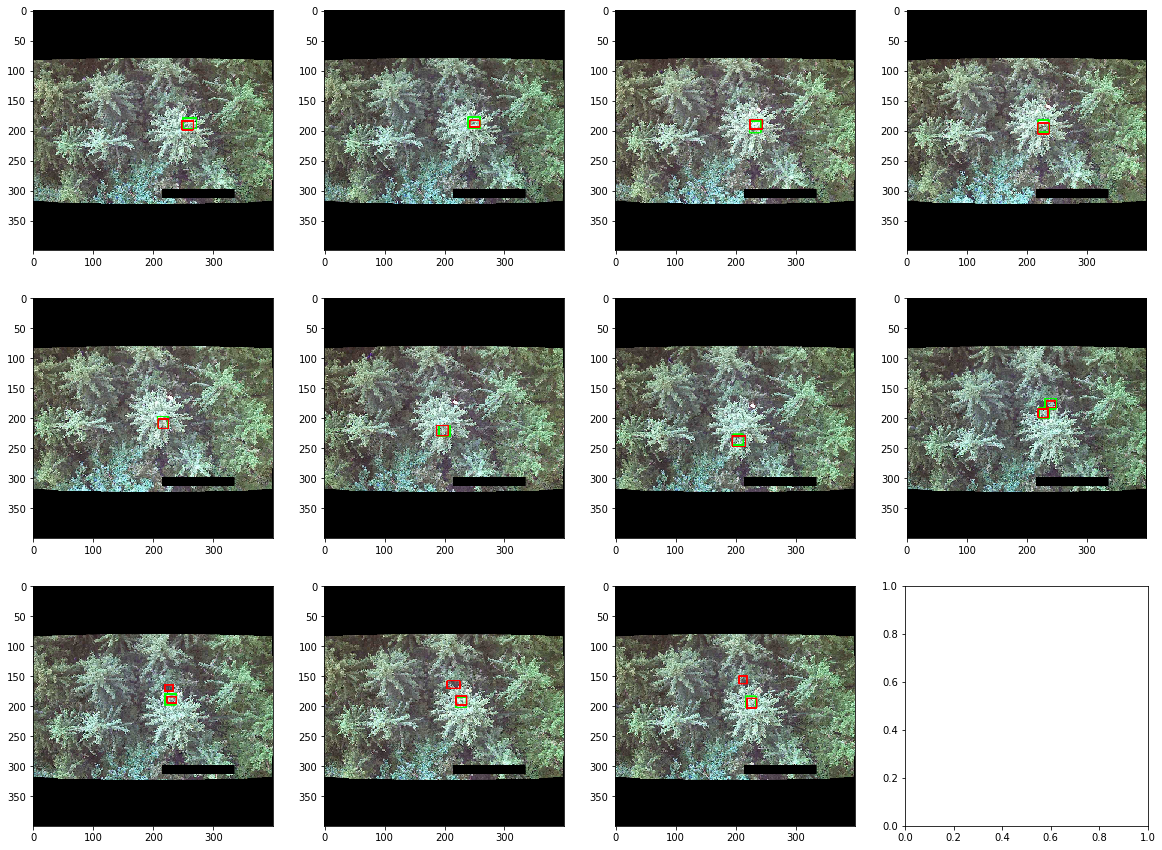

In [63]:
results = copy.deepcopy(main_labels)
img_res = []

for folder, boxes in main_labels.items():
    """
    Select which images to overlay bounding boxes onto below
    by swapping commented lines
    """
    #temp_img = integrated_images[folder]['3'].copy()
    temp_img = orig_images[folder]['3']['3-B01'].copy()
    
    temp_img = add_bounding_boxes(temp_img, boxes, rgb_color=(0,255,0))
    temp_img = add_bounding_boxes(temp_img, labels[folder], rgb_color=(255,0,0))
    results[folder] = temp_img
    img_res.append(temp_img)

display_images(np.array(img_res), figsize=(3,4), resize_dim=(400,400))

### Average Precision
The AP is only calculated on the validation set.

In [64]:
result = ut.compute_AP(main_labels,labels)
print(f"{result*100:.2f}%")

57.22%
